# Spam detection using Character RNN's

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
torch.backends.cudnn.deterministic = True

In [ ]:
torch.seed()

17812487932005069803

In [ ]:
f = open('/content/SMSSpamCollection')
for _ in range(5):
  line = f.readline()
  print(line)

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

ham	Ok lar... Joking wif u oni...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

ham	U dun say so early hor... U c already then say...

ham	Nah I don't think he goes to usf, he lives around here though



In [ ]:
for line in open('SMSSpamCollection'):
    if 'ham' in line:
      print(line)
      break
for line in open('SMSSpamCollection'):
    if 'spam' in line:
      print(line)
      break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



In [ ]:
ham = 0
spam = 0

for line in open('SMSSpamCollection'):
  if line[:3] == 'ham':
    ham += 1
  if line[:3] == 'spa':
    spam += 1
print('Ham Count: {}, Spam Count: {}'.format(ham,spam))

Ham Count: 4827, Spam Count: 747


In [ ]:
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

# dataset[0].sms
# dataset[0].label
train, valid, test = dataset.split(split_ratio = [0.6,0.2,0.2])

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

In [ ]:
text_field.build_vocab(train)
#text_field.vocab.stoi
#text_field.vocab.itos

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
i = 0
input_length = [0]*10 
num_pads = [0]*10 

for batch in train_iter:
  if i < 10:
    for text in batch.sms[0]:
      input_length[i] = len(text) #max(batch.sms[1])
      for char in text:
        if char == text_field.vocab.stoi["<pad>"]:
          num_pads[i] += 1
    i += 1        

print('Maximum lengths of input sequence in each batch:',input_length)
print('Number of pad tokens used in each batch:',num_pads)

Maximum lengths of input sequence in each batch: [76, 85, 29, 72, 38, 166, 223, 82, 153, 50]
Number of pad tokens used in each batch: [49, 31, 27, 27, 4, 37, 907, 39, 0, 24]


In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


## RNN model

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size,out_type = 2):
    super(RNN, self).__init__()
    self.emb = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.out_type = out_type
    self.name = 'RNN'
    self.rnn = nn.RNN(input_size,hidden_size,batch_first=True)
    self.fc = nn.Linear(hidden_size,2)

  def forward(self,input):

    input = self.emb[input]
    #print(input[0][0])
    h0 = torch.zeros(1,input.size(0),self.hidden_size)
    out, _ = self.rnn(input, h0)

    if self.out_type == 1:
      out = self.fc(out[:,-1,:])
      return out
    if self.out_type == 2:
      out = self.fc(torch.max(out, dim=1)[0])
      return out
    if self.out_type == 3:
      out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
      return out

In [ ]:
def get_accuracy(model, valid,criterion, isvalid = False):

    correct = 0
    total = 0
    n = 0
    total_loss = 0
    for data in valid:
        
        output = model(data.sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(data.label.view_as(pred)).sum().item()
        total += data.label.shape[0]

        if isvalid:
          loss = criterion(output,data.label)
          total_loss += loss.item()
          n += 1
    return (float(correct / total),(float(total_loss)/(n+1)) )if isvalid else float(correct / total)

In [ ]:
# def val_loss(model, valid, criterion):
#   n = 0
#   total_loss = 0
#   for data in valid:
#     output = model(data.sms[0])
#     loss = criterion(output, data.label)
#     total_loss += loss.item()
#     n += 1
#   vloss = float(total_loss)/(n+1)
#   return vloss

In [ ]:
def train_rnn_network(model,train,valid,num_epochs = 5,batch_size = 32,learning_rate = 1e-5,visualize = False):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_acc,val_acc,valid_loss = np.zeros(num_epochs),np.zeros(num_epochs),np.zeros(num_epochs)
    iters,losses = [], []

    n = 0

    print('Loading Data...')
    train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
    valid_iter = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
    print('Data Loaded...')                                           
    for epoch in range(num_epochs):

        for data in iter(train_iter):

            out = model(data.sms[0])             # forward pass
            loss = criterion(out, data.label) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1          

        # save the current training information
        iters.append(n)

        losses.append(float(loss)/batch_size)   # compute *average* loss

        # track accuracy
        train_acc[epoch] = get_accuracy(model, train_iter,criterion=criterion)
        val_acc[epoch],valid_loss[epoch] = get_accuracy(model,valid_iter,
                                                        criterion = criterion,
                                                        isvalid=True)

        print(("Epoch : {}/{} , Training acc: {} ,Training loss: {},\
         || Validation acc: {}  , Validation loss: {}").format(epoch+1,
                                                               num_epochs,
                                                               train_acc[epoch],
                                                               losses[-1],
                                                               val_acc[epoch],
                                                               valid_loss[epoch]))
        print(("").format())

        model_path = "{}_epoch_{}".format(model.name,epoch+1)
        torch.save(model.state_dict(), model_path)

    if visualize:
      #plotting loss
      plt.title("Training Curve")
      plt.plot(iters, losses, label="Train")
      plt.plot(iters,valid_loss,label = 'Valid')
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      plt.legend(loc='best')
      plt.show()
      
      #plotting accuracy
      plt.title("Training Curve")
      plt.plot(iters, train_acc, label="Train")
      plt.plot(iters, val_acc, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend(loc='best')
      plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Loading Data...
Data Loaded...
Epoch : 1/30 , Training acc: 0.8242142025611175 ,Training loss: 0.020420445129275322, || Validation acc: 0.6852017937219731  , Validation loss: 0.6475568463404974

Epoch : 2/30 , Training acc: 0.9402960252785632 ,Training loss: 0.009199853986501694, || Validation acc: 0.9291479820627803  , Validation loss: 0.32263556702269447

Epoch : 3/30 , Training acc: 0.9574255779145185 ,Training loss: 0.006972815375775099, || Validation acc: 0.9452914798206278  , Validation loss: 0.19669582549896505

Epoch : 4/30 , Training acc: 0.9565940462331615 ,Training loss: 0.003512126859277487, || Validation acc: 0.9443946188340807  , Validation loss: 0.19089397684567505

Epoch : 5/30 , Training acc: 0.9682354897721603 ,Training loss: 0.0018474900862202048, || Validation acc: 0.9605381165919282  , Validation loss: 0.13594922702759504

Epoch : 6/30 , Training acc: 0.9723931481789456 ,Training loss: 0.0014614673564210534, || Validation acc: 0.967713004484305  , Validation loss: 

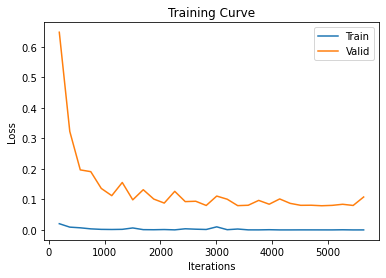

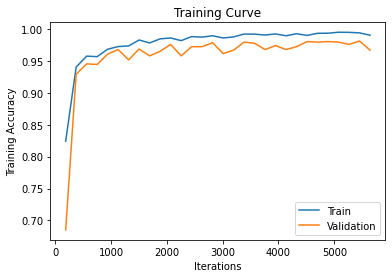

Final Training Accuracy: 0.9901879261599867
Final Validation Accuracy: 0.9668161434977578


In [ ]:
model_1 = RNN(input_size = len(text_field.vocab),hidden_size = 10)
train_rnn_network(model_1, train, valid,num_epochs=30, learning_rate=1e-3, visualize = True)

### Hyperparameter tuning


In [ ]:
model_2 = RNN(input_size = len(text_field.vocab),hidden_size = 10, out_type = 1)
model_2.name = 'model_2'
train_rnn_network(model_2, train, valid,num_epochs=10, learning_rate=1e-3)

Loading Data...
Data Loaded...
Epoch : 1/10 , Training acc: 0.6885082321636454 ,Training loss: 0.02033305913209915, || Validation acc: 0.736322869955157  , Validation loss: 0.6444610837433074

Epoch : 2/10 , Training acc: 0.9053716946615666 ,Training loss: 0.005759681109338999, || Validation acc: 0.9291479820627803  , Validation loss: 0.26101694338851505

Epoch : 3/10 , Training acc: 0.8637951105937136 ,Training loss: 0.021474722772836685, || Validation acc: 0.9372197309417041  , Validation loss: 0.2380759751217233

Epoch : 4/10 , Training acc: 0.9249958423415933 ,Training loss: 0.016875408589839935, || Validation acc: 0.9695067264573991  , Validation loss: 0.1646513988574346

Epoch : 5/10 , Training acc: 0.9293198070846499 ,Training loss: 0.005058414302766323, || Validation acc: 0.9650224215246637  , Validation loss: 0.1695484309974644

Epoch : 6/10 , Training acc: 0.8494927656743722 ,Training loss: 0.009275684133172035, || Validation acc: 0.9327354260089686  , Validation loss: 0.2680

In [ ]:
model_3 = RNN(input_size = len(text_field.vocab),hidden_size = 10, out_type = 2)
model_3.name = 'model_3'
train_rnn_network(model_3, train, valid,num_epochs=10, learning_rate=1e-3)

Loading Data...
Data Loaded...
Epoch : 1/10 , Training acc: 0.5203725261932479 ,Training loss: 0.02327704429626465, || Validation acc: 0.13004484304932734  , Validation loss: 0.695569697353575

Epoch : 2/10 , Training acc: 0.935805754199235 ,Training loss: 0.017404448240995407, || Validation acc: 0.9434977578475336  , Validation loss: 0.5359068074160152

Epoch : 3/10 , Training acc: 0.9409612506236488 ,Training loss: 0.011377697810530663, || Validation acc: 0.9614349775784753  , Validation loss: 0.30208175463808906

Epoch : 4/10 , Training acc: 0.9499417927823051 ,Training loss: 0.00829506665468216, || Validation acc: 0.9659192825112107  , Validation loss: 0.19968390464782715

Epoch : 5/10 , Training acc: 0.9497754864460336 ,Training loss: 0.003985485527664423, || Validation acc: 0.957847533632287  , Validation loss: 0.17459012505908808

Epoch : 6/10 , Training acc: 0.9526026941626476 ,Training loss: 0.0028972504660487175, || Validation acc: 0.967713004484305  , Validation loss: 0.1293

In [ ]:
model_4 = RNN(input_size = len(text_field.vocab),hidden_size = 10, out_type = 3)
model_4.name = 'model_4'
train_rnn_network(model_4, train, valid,num_epochs=10, learning_rate=1e-3)

Loading Data...
Data Loaded...
Epoch : 1/10 , Training acc: 0.5569599201729586 ,Training loss: 0.0666290819644928, || Validation acc: 0.20986547085201793  , Validation loss: 2.023954153060913

Epoch : 2/10 , Training acc: 0.5922168634624979 ,Training loss: 0.058188296854496, || Validation acc: 0.7542600896860987  , Validation loss: 1.813897540171941

Epoch : 3/10 , Training acc: 0.591052719108598 ,Training loss: 0.055394016206264496, || Validation acc: 0.7542600896860987  , Validation loss: 1.7166416413254209

Epoch : 4/10 , Training acc: 0.5787460502245135 ,Training loss: 0.05313120037317276, || Validation acc: 0.7390134529147983  , Validation loss: 1.6525821917586856

Epoch : 5/10 , Training acc: 0.6367869615832363 ,Training loss: 0.051830459386110306, || Validation acc: 0.6798206278026906  , Validation loss: 1.6137178507116106

Epoch : 6/10 , Training acc: 0.612838849160153 ,Training loss: 0.05111275240778923, || Validation acc: 0.7130044843049327  , Validation loss: 1.5830773280726

From the above results, out_type 2 performs better of all in terms of accuracy, so from here on we will only use this type to predict the output.


In [ ]:
%%time
model_5 = RNN(input_size = len(text_field.vocab),hidden_size = 5, out_type = 2)
model_5.name = 'model_5'
train_rnn_network(model_5, train, valid,num_epochs=30, learning_rate=1e-3)
print('\n')

Loading Data...
Data Loaded...
Epoch : 1/30 , Training acc: 0.5180442374854481 ,Training loss: 0.0236948411911726, || Validation acc: 0.1273542600896861  , Validation loss: 0.7182825439506106

Epoch : 2/30 , Training acc: 0.5717611841011142 ,Training loss: 0.02233540266752243, || Validation acc: 0.23497757847533632  , Validation loss: 0.6822577897045348

Epoch : 3/30 , Training acc: 0.9123565607849659 ,Training loss: 0.018147971481084824, || Validation acc: 0.9013452914798207  , Validation loss: 0.5951326522562239

Epoch : 4/30 , Training acc: 0.9384666555795775 ,Training loss: 0.014394903555512428, || Validation acc: 0.9641255605381166  , Validation loss: 0.4322839669055409

Epoch : 5/30 , Training acc: 0.9509396307999335 ,Training loss: 0.008588908240199089, || Validation acc: 0.9659192825112107  , Validation loss: 0.2951357737183571

Epoch : 6/30 , Training acc: 0.9552635955429902 ,Training loss: 0.0065859220921993256, || Validation acc: 0.967713004484305  , Validation loss: 0.21510

With lower number of hidden state dimensions, the validation accuracy of the model tends to flatten after few epochs, this could be reason due to less number of parameters to learn.

In [ ]:
%%time
model_6 = RNN(input_size = len(text_field.vocab),hidden_size = 15, out_type = 2)
model_6.name = 'model_6'
train_rnn_network(model_6, train, valid, num_epochs=15, learning_rate=1e-3)
print('\n')

Loading Data...
Data Loaded...
Epoch : 1/15 , Training acc: 0.9323133211375353 ,Training loss: 0.014123281463980675, || Validation acc: 0.9713004484304932  , Validation loss: 0.4257356814212269

Epoch : 2/15 , Training acc: 0.9544320638616332 ,Training loss: 0.006926279515028, || Validation acc: 0.9713004484304932  , Validation loss: 0.17349532267285717

Epoch : 3/15 , Training acc: 0.9564277398968901 ,Training loss: 0.005460591055452824, || Validation acc: 0.9766816143497757  , Validation loss: 0.12412333654032813

Epoch : 4/15 , Training acc: 0.9660735074006319 ,Training loss: 0.001938255038112402, || Validation acc: 0.9614349775784753  , Validation loss: 0.1716100455572208

Epoch : 5/15 , Training acc: 0.9622484616663894 ,Training loss: 0.002029873663559556, || Validation acc: 0.9704035874439462  , Validation loss: 0.10323084383789036

Epoch : 6/15 , Training acc: 0.9624147680026609 ,Training loss: 0.0032108037266880274, || Validation acc: 0.9730941704035875  , Validation loss: 0.08

with hidden size of 15, we are able to achieve slightly better performance of base model(hidden size = 10) with in 15 epochs. So, the increase in number of parameters makes our model to learn better. We will increase the hidden size further and decide the hidden size.

In [ ]:
%%time
model_7 = RNN(input_size = len(text_field.vocab),hidden_size = len(text_field.vocab), out_type = 2)
model_7.name = 'model_7'
train_rnn_network(model_7, train, valid,num_epochs=10, learning_rate=1e-3)
print('\n')

Loading Data...
Data Loaded...
Epoch : 1/10 , Training acc: 0.9522700814901047 ,Training loss: 0.0034331222996115685, || Validation acc: 0.9748878923766816  , Validation loss: 0.13404492951101726

Epoch : 2/10 , Training acc: 0.9698985531348744 ,Training loss: 0.002151862485334277, || Validation acc: 0.9587443946188341  , Validation loss: 0.12107050832774904

Epoch : 3/10 , Training acc: 0.9725594545152171 ,Training loss: 0.0024725045077502728, || Validation acc: 0.9820627802690582  , Validation loss: 0.06485010722341637

Epoch : 4/10 , Training acc: 0.97172792283386 ,Training loss: 0.0005904097342863679, || Validation acc: 0.9363228699551569  , Validation loss: 0.16180699701524442

Epoch : 5/10 , Training acc: 0.9866954930982871 ,Training loss: 0.000268277944996953, || Validation acc: 0.9829596412556054  , Validation loss: 0.05697090381808165

Epoch : 6/10 , Training acc: 0.9833693663728588 ,Training loss: 0.0009609885746613145, || Validation acc: 0.9802690582959641  , Validation loss

As very large number of parameters made our model to overfit, we will try with hidden size of 50 along with adjusting learning rate.

First we will try to find the best learning rate with large number of hidden dimensions.

In [ ]:
%%time
model_8 = RNN(input_size = len(text_field.vocab),hidden_size = len(text_field.vocab), out_type = 2)
model_8.name = 'model_8'
train_rnn_network(model_8, train, valid,num_epochs=15, learning_rate=5e-4)
print('\n')

Loading Data...
Data Loaded...
Epoch : 1/15 , Training acc: 0.9402960252785632 ,Training loss: 0.01301592867821455, || Validation acc: 0.9596412556053812  , Validation loss: 0.36593010773261386

Epoch : 2/15 , Training acc: 0.9564277398968901 ,Training loss: 0.004827865865081549, || Validation acc: 0.9560538116591928  , Validation loss: 0.16718624159693718

Epoch : 3/15 , Training acc: 0.9600864792948611 ,Training loss: 0.004028782714158297, || Validation acc: 0.9650224215246637  , Validation loss: 0.11308781295600864

Epoch : 4/15 , Training acc: 0.965241975719275 ,Training loss: 0.0021789371967315674, || Validation acc: 0.9605381165919282  , Validation loss: 0.12094834633171558

Epoch : 5/15 , Training acc: 0.9690670214535174 ,Training loss: 0.0010433006100356579, || Validation acc: 0.9659192825112107  , Validation loss: 0.09632633978294002

Epoch : 6/15 , Training acc: 0.9758855812406453 ,Training loss: 0.002004663459956646, || Validation acc: 0.9721973094170404  , Validation loss: 

Although this model gave best result, it tends to overfit the training data, so we will try to reduce the hidden size to 50 with same learning rate. But change the batch size to converge faster without overfitting.

In [ ]:
%%time
model_9 = RNN(input_size = len(text_field.vocab),hidden_size = 50, out_type = 2)
model_9.name = 'model_9'
train_rnn_network(model_9, train, valid,num_epochs=15, learning_rate=5e-4,batch_size=8)
print('\n')

Loading Data...
Data Loaded...
Epoch : 1/15 , Training acc: 0.9517711624812906 ,Training loss: 0.007119743153452873, || Validation acc: 0.9641255605381166  , Validation loss: 0.14084328977879904

Epoch : 2/15 , Training acc: 0.9615832363213038 ,Training loss: 0.004440195858478546, || Validation acc: 0.967713004484305  , Validation loss: 0.10587628682454427

Epoch : 3/15 , Training acc: 0.9725594545152171 ,Training loss: 0.0032237700652331114, || Validation acc: 0.9650224215246637  , Validation loss: 0.1075327894088964

Epoch : 4/15 , Training acc: 0.9775486446033594 ,Training loss: 0.011375676840543747, || Validation acc: 0.9704035874439462  , Validation loss: 0.08844422428135543

Epoch : 5/15 , Training acc: 0.9817063030101447 ,Training loss: 0.006787954363971949, || Validation acc: 0.9748878923766816  , Validation loss: 0.08078408348274992

Epoch : 6/15 , Training acc: 0.9738899052053883 ,Training loss: 0.0009693511528894305, || Validation acc: 0.9820627802690582  , Validation loss: 

The above model didn't perform as expected. So, experimenting the model with previous hidden size as it gave better results.

In [ ]:
%%time
model_10 = RNN(input_size = len(text_field.vocab),hidden_size = len(text_field.vocab), out_type = 2)
model_10.name = 'model_10'
train_rnn_network(model_10, train, valid,num_epochs=15, learning_rate=5e-4,batch_size=16)
print('\n')

Loading Data...
Data Loaded...
Epoch : 1/15 , Training acc: 0.9536005321802761 ,Training loss: 0.02453790418803692, || Validation acc: 0.9721973094170404  , Validation loss: 0.16675588960798693

Epoch : 2/15 , Training acc: 0.9639115250291036 ,Training loss: 0.001343687647022307, || Validation acc: 0.95695067264574  , Validation loss: 0.14207664945385826

Epoch : 3/15 , Training acc: 0.9644104440379179 ,Training loss: 0.0014597648987546563, || Validation acc: 0.9488789237668162  , Validation loss: 0.17267808433569654

Epoch : 4/15 , Training acc: 0.9758855812406453 ,Training loss: 0.01602531410753727, || Validation acc: 0.9775784753363229  , Validation loss: 0.07941492757117244

Epoch : 5/15 , Training acc: 0.9805421586562448 ,Training loss: 0.006237176712602377, || Validation acc: 0.9811659192825112  , Validation loss: 0.06494649145489848

Epoch : 6/15 , Training acc: 0.9876933311159155 ,Training loss: 0.000567249022424221, || Validation acc: 0.979372197309417  , Validation loss: 0.05

This model gave the best results till now with validation accuracy of 98.47% at 10th epoch.

In [ ]:
%%time
model_11 = RNN(input_size = len(text_field.vocab),hidden_size = len(text_field.vocab), out_type = 2)
model_11.name = 'model_11'
train_rnn_network(model_11, train, valid,num_epochs=15, learning_rate=5e-4,batch_size=64)
print('\n')

Loading Data...
Data Loaded...
Epoch : 1/15 , Training acc: 0.9254947613504074 ,Training loss: 0.00883531104773283, || Validation acc: 0.9730941704035875  , Validation loss: 0.5220498175997483

Epoch : 2/15 , Training acc: 0.9431232329951771 ,Training loss: 0.005946161225438118, || Validation acc: 0.9533632286995516  , Validation loss: 0.3442166322156003

Epoch : 3/15 , Training acc: 0.8386828538167305 ,Training loss: 0.007951997220516205, || Validation acc: 0.9551569506726457  , Validation loss: 0.1474047279671619

Epoch : 4/15 , Training acc: 0.9560951272243472 ,Training loss: 0.0021567009389400482, || Validation acc: 0.9721973094170404  , Validation loss: 0.15804580834351087

Epoch : 5/15 , Training acc: 0.958423415932147 ,Training loss: 0.00039485780871473253, || Validation acc: 0.9713004484304932  , Validation loss: 0.12372773924940511

Epoch : 6/15 , Training acc: 0.955596208215533 ,Training loss: 0.0025393220130354166, || Validation acc: 0.9748878923766816  , Validation loss: 0.

In [ ]:
%%time
model_12 = RNN(input_size = len(text_field.vocab),hidden_size = len(text_field.vocab), out_type = 2)
model_12.name = 'model_12'
train_rnn_network(model_12, train, valid,num_epochs=15, learning_rate=5e-4,batch_size=128)
print('\n')

Loading Data...
Data Loaded...
Epoch : 1/15 , Training acc: 0.519208381839348 ,Training loss: 0.005664824973791838, || Validation acc: 0.12825112107623318  , Validation loss: 0.6506624102592469

Epoch : 2/15 , Training acc: 0.9411275569599201 ,Training loss: 0.004738071467727423, || Validation acc: 0.9488789237668162  , Validation loss: 0.5114280343055725

Epoch : 3/15 , Training acc: 0.9376351238982206 ,Training loss: 0.0017665778286755085, || Validation acc: 0.9452914798206278  , Validation loss: 0.3341741174459457

Epoch : 4/15 , Training acc: 0.9228338599700648 ,Training loss: 0.0010683397995308042, || Validation acc: 0.8923766816143498  , Validation loss: 0.37366925477981566

Epoch : 5/15 , Training acc: 0.9449526026941627 ,Training loss: 0.0013588527217507362, || Validation acc: 0.9587443946188341  , Validation loss: 0.18276422172784806

Epoch : 6/15 , Training acc: 0.9539331448528189 ,Training loss: 0.0010080449283123016, || Validation acc: 0.9596412556053812  , Validation loss:

As we can observe the accuracy is reducing as we increase the batch size, so we will terminate the tuning and analyze the best model.

The model 10 (Batch size: 16, learning rate : 5e-4, out_type : 2, epoch: 10, hidden size : len(text_field.vocab)) acheived a validation accuracy of 98.47% at 10th epoch and seems to have lowest validation loss among all other models.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)

valid_spam_iter = torchtext.legacy.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)  

# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

valid_nospam_iter = torchtext.legacy.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)  

In [ ]:
model = RNN(input_size = len(text_field.vocab),hidden_size = len(text_field.vocab), out_type = 2)
state = torch.load('model_10_epoch_10')
model.load_state_dict(state)

<All keys matched successfully>

In [ ]:
fnr = 1 - get_accuracy(model,valid = valid_spam_iter,criterion=None)
print('False negative rate :',fnr)
fpr = 1 - get_accuracy(model,valid = valid_nospam_iter,criterion=None)
print('False positive rate :',fpr)

False negative rate : 0.09859154929577463
False positive rate : 0.004110996916752319


In [ ]:
test_iter = torchtext.legacy.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False) 
testacc = get_accuracy(model,test_iter,criterion=None)
print('Testing Accuracy:',round(testacc,3)*100,'%')

Testing Accuracy: 97.89999999999999 %


In [ ]:
# Analyzing the model with Spam data
test_spam = torchtext.legacy.data.Dataset(
    [t for t in test.examples if t.label == 1],test.fields)

test_spam_iter = torchtext.legacy.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)  

# Analyzing the model with non-Spam data
test_nospam = torchtext.legacy.data.Dataset(
    [t for t in test.examples if t.label == 0],
    test.fields)

test_nospam_iter = torchtext.legacy.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)  

In [ ]:
fnr = 1 - get_accuracy(model,valid = test_spam_iter,criterion=None)
print('False negative rate :',fnr)
fpr = 1 - get_accuracy(model,valid = test_nospam_iter,criterion=None)
print('False positive rate :',fpr)

False negative rate : 0.08750000000000002
False positive rate : 0.010482180293501009


In [ ]:
msg = "machine learning is sooo cool!"

tokens = []

for c in msg:
  tokens.append(torch.tensor(text_field.vocab.stoi[c]))
msg = torch.LongTensor([tokens])
pred = model(msg)
prob = F.softmax(pred,dim = 1)
print('The probability that the given message is spam is:',float(prob[0][1]))

The probability that the given message is spam is: 0.0015399408293887973


## Improving the model using Transfer learning

In [ ]:
# install relevant libraries
!pip install fastai

In [ ]:
# load relevant libraries
from fastai import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from fastai.text import *

In [ ]:
# # download SPAM data
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
# !unzip smsspamcollection.zip

In [ ]:
# set up data and verify
df1 = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
df1.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# check distribution
df1['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

Split the data into training and validation datasets.

In [ ]:
# split the data and check dimensions

from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df1, stratify = df1['target'], test_size = 0.3, random_state = 999)

In [ ]:
df_trn.shape, df_val.shape

((3900, 2), (1672, 2))

In [ ]:
vars(train[0])

{'label': 1,
 'sms': 'URGENT! We are trying to contact U. Todays draw shows that you have won a £800 prize GUARANTEED. Call 09050001808 from land line. Claim M95. Valid12hrs only'}

In [ ]:
def createDF(data):
  sms,label = [],[]
  for batch in data:
    sms.append(batch.sms)
    label.append(batch.label)
  return pd.DataFrame({'target':label,'text':sms})

In [ ]:
df_train = createDF(train)
df_valid = createDF(valid)
df_test = createDF(test)

### Creating the language model

In [ ]:
# create pretrained language model data
data_lm = TextLMDataBunch.from_df(train_df = df_train, valid_df = df_valid, test_df= df_test, path = "")
lang_mod = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=1.)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


### Testing the language model


In [ ]:
for i in range(5):
  print(lang_mod.predict("The problem usually starts when", n_words=10))

The problem usually starts when the first two starts are common . Because of
The problem usually starts when Head and head are sit on a sofa ,
The problem usually starts when the amount of time necessary to complete a match is
The problem usually starts when 3D s 3D is usually the idea of
The problem usually starts when the two best - available or different players are either


In [ ]:
for i in range(5):
  print(lang_mod.predict("Nyquist frequency is", n_words=10))

Nyquist frequency is a Tuesday ; it is used to celebrate a
Nyquist frequency is a show by American actor John Agalla
Nyquist frequency is a character of the New Common Day
Nyquist frequency is American skype explicit in their reference to a
Nyquist frequency is a British horny book about his partner 's life


In [ ]:
for i in range(5):
  print(lang_mod.predict("Humans are", n_words=10))

Humans are American Indian school members . They were
Humans are well - off simple English small - name islands
Humans are true kinda things that are not , and do not
Humans are laid together on Earth by however recd Earth
Humans are made possible by the American Red Ship


In [ ]:
# fine-tune language model data
lang_mod.fit_one_cycle(4, max_lr= 5e-02)
lang_mod.freeze_to(-1)
lang_mod.fit_one_cycle(3, slice(1e-2/(2.6**4), 1e-2))
lang_mod.freeze_to(-2)
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))
lang_mod.unfreeze()
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))

# save language model
lang_mod.save_encoder('my_awsome_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,5.567480,3.940609,0.271429,00:06
1,4.835373,3.966326,0.328571,00:06
2,4.377582,3.808568,0.300000,00:06
3,4.062694,3.793522,0.285714,00:06


epoch,train_loss,valid_loss,accuracy,time
0,3.596324,3.758959,0.300000,00:06
1,3.543268,3.761344,0.300000,00:06
2,3.478009,3.760065,0.300000,00:06


epoch,train_loss,valid_loss,accuracy,time
0,3.403165,3.765799,0.300000,00:06
1,3.376465,3.782758,0.300000,00:06
2,3.356297,3.787157,0.285714,00:06


epoch,train_loss,valid_loss,accuracy,time
0,3.332972,3.801882,0.257143,00:08
1,3.283875,3.780165,0.285714,00:08
2,3.242095,3.788045,0.285714,00:08


### Creating the Classification model

In [ ]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_train,  valid_df = df_valid, test_df= df_test, vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
data_clas.show_batch()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
"xxbos xxmaj the last thing i ever wanted to do was hurt you . xxmaj and i did n't think it would have . xxmaj you 'd laugh , be embarassed , delete the xxunk and keep going . xxmaj but as far as i knew , it was n't even up . xxmaj the fact that you even felt like i would do it to hurt you shows you",ham
xxbos xxmaj for me the love should start with xxunk should feel that i need her every time around xxunk should be the first thing which comes in my thoughts . i would start the day and end it with xxunk should be there every time i xxunk will be then when my every breath has her xxunk life should happen around xxunk life will be named to her .,ham
xxbos xxmaj how to xxmaj make a girl xxmaj happy ? xxmaj it 's not at all difficult to make girls happy . u only need to be ... 1 . a friend 2 . xxmaj xxunk 3 . xxmaj lover 4 . xxmaj xxunk . . . < # > . xxmaj good xxunk < # > . xxmaj xxunk < # > . xxmaj good boyfriend < #,ham
"xxbos xxmaj indians r poor but xxmaj india is not a poor country . xxmaj says one of the swiss bank xxunk . xxmaj he says that "" < # > xxunk crore "" of xxmaj indian money is xxunk in swiss banks which can be used for ' xxunk ' budget for < # > yrs . xxmaj can give < # > crore xxunk to all xxmaj indians",ham
"xxbos no , i * did n't * mean to post it . i wrote it , and like so many other times i 've xxunk stuff to you , i let it sit there . it xxup was what i was feeling at the time . i was angry . xxmaj before i left , i hit send , then stop . xxmaj it was n't there . i",ham


In [ ]:
# creating the classifier
learn_classifier = text_classifier_learner(data_clas, drop_mult=0.7, arch = AWD_LSTM)

In [ ]:
# load language model
learn_classifier.load_encoder('my_awsome_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (3900 items)
x: TextList
xxbos i liked your new house,xxbos xxmaj xxunk i 'm walking in xxunk now ü faster come down ... xxmaj me very hungry ...,xxbos xxmaj wan2 win a meet+greet with xxmaj westlife 4 u or a m8 ? xxmaj they are currently on what tour ? 1)unbreakable , 2)untamed , 3)unkempt . xxmaj text 1,2 or 3 to 83049 . xxmaj cost 50p + std text,xxbos xxmaj otherwise had part time job na - tuition ..,xxbos xxmaj wait , do you know if xxunk in town ? i bet she does hella drugs !
y: CategoryList
ham,ham,spam,ham,ham
Path: .;

Valid: LabelList (1672 items)
x: TextList
xxbos xxmaj not a lot has happened here . xxmaj feels very xxunk . xxmaj xxunk is at her xxunk and xxunk is working lots . xxmaj just me and xxunk in at the mo . xxmaj how have you been ?,xxbos xxmaj the current xxunk bid is xxunk . xxmaj to xxunk this auction send xxup out . xxmaj customer xxmaj care : xxunk,xxbos xxmaj are you free xxunk i call now ?,xxbos xxmaj cold 

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E+00
Min loss divided by 10: 5.25E-02


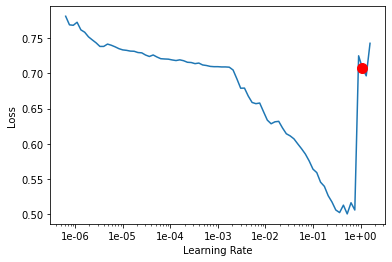

In [ ]:
# train classifier
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [ ]:
learn_classifier.fit_one_cycle(5, max_lr=1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.356379,0.092090,0.977871,00:09
1,0.183426,0.070037,0.983852,00:08
2,0.115915,0.088985,0.982057,00:08
3,0.087863,0.104869,0.979067,00:08
4,0.067741,0.095811,0.981459,00:08


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

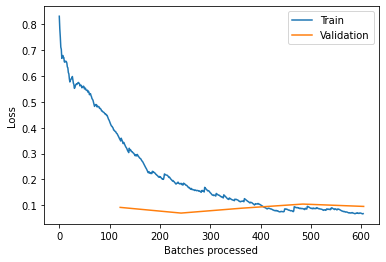

In [ ]:
learn_classifier.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 1.45E-06


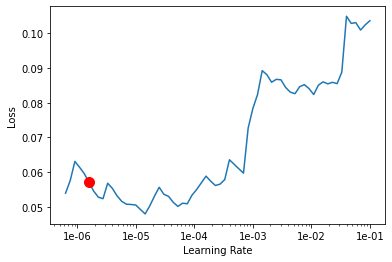

In [ ]:
lang_mod.freeze_to(-1)

learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

Testing the classification model on spam and non-spam examples.

In [ ]:
# predict
learn_classifier.predict('did you buy the groceries for dinner? :)')

(Category tensor(0), tensor(0), tensor([9.9991e-01, 9.0493e-05]))

In [ ]:
# predict
learn_classifier.predict('Free entry call back now')

(Category tensor(1), tensor(1), tensor([0.3264, 0.6736]))

Next we will evaluate on all of our validation data.

In [ ]:
# get predictions from validation
valid_preds, valid_label=learn_classifier.get_preds(ds_type=DatasetType.Valid, ordered=True)
valid_preds.shape

Extracting actual labels of test data.

In [ ]:
tactual= [i.label for i in test] #Extracting true test labels
tactual = torch.tensor(tactual)

In [ ]:
# get predictions from Test uning ULMFiT model
test_preds, _ = learn_classifier.get_preds(ds_type=DatasetType.Test, ordered=True)
test_preds.shape

torch.Size([1114, 2])

Test Accuracy of ULMFiT model

In [ ]:
correct, total = 0,0
pred = test_preds.max(1, keepdim=True)[1]
correct += pred.eq(torch.tensor(tactual).view_as(pred)).sum().item()
total += torch.tensor(tactual).shape[0]
print('Testing Accuracy of ULMFiT model :',round(float(correct/total),5)*100,'%')

Testing Accuracy of ULMFiT model : 98.115 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


Test accuracy using basic model

In [ ]:
test_iter = torchtext.legacy.data.BucketIterator(test,
                                           batch_size=1,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)  

In [ ]:
testacc = get_accuracy(model,test_iter,criterion=None)
print('Testing Accuracy of Trained model:',round(testacc,5)*100,'%')

Testing Accuracy of Trained model: 98.02499999999999 %


Extracting model's predicted labels from test data.

In [ ]:
t_pred = np.empty(len(test))
i = 0

correct,total = 0,0
for data in test:
  tokens = []
  for c in data.sms:
    tokens.append(torch.tensor(text_field.vocab.stoi[c]))
  msg = torch.LongTensor([tokens])
  tpred = model(msg)
  t_pred[i] = tpred.max(1, keepdim=True)[1]
  i += 1

## Evaluating the models

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
confusion_matrix(tactual,pred) #ULMFiT

array([[954,   0],
       [ 21, 139]])

In [ ]:
confusion_matrix(tactual,t_pred) #model from part A

array([[945,   9],
       [ 13, 147]])

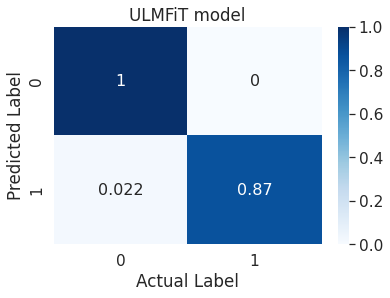

In [ ]:
cm_array = confusion_matrix(tactual,pred)
df_cm = pd.DataFrame((cm_array/np.sum(cm_array,axis = 1)))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap='Blues',annot=True, annot_kws={"size": 16})
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.title('ULMFiT model')
plt.show()

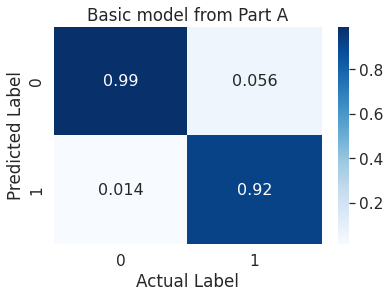

In [ ]:
cm_array = confusion_matrix(tactual,t_pred) 
df_cm = pd.DataFrame((cm_array/np.sum(cm_array,axis = 1)))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap='Blues',annot=True, annot_kws={"size": 16})
plt.xlabel('Actual Label')
plt.ylabel('Predicted Label')
plt.title('Basic model from Part A')
plt.show()

## Testing the models on real user data

In [ ]:
msg = "machine learning is sooo cool!"

tokens = []

for c in msg:
  tokens.append(torch.tensor(text_field.vocab.stoi[c]))
msg = torch.LongTensor([tokens])
pred = model(msg)
prob = F.softmax(pred,dim = 1)
f'The probability that the given message is spam is:',float(prob[0][1])

('The probability that the given message is spam is:', 0.0015399408293887973)

In [ ]:
def test_msg(msg):
  tokens = []
  for c in msg:
    tokens.append(torch.tensor(text_field.vocab.stoi[c]))
  msg = torch.LongTensor([tokens])
  pred = model(msg)
  prob = F.softmax(pred,dim = 1)[0][1]
  return round(float(prob),4)*100

In [ ]:
spam1 = "We have finally succeeded in getting your  funds worth of $10.8Million Us Dollars, enter your ATM MASTER CARD details"
print('Probability of spam with ULMFiT model: ',np.array(learn_classifier.predict(spam1)[2][1])*100,'%')
print('Probability of spam with Part A model: ',test_msg(spam1),'%')

Probability of spam with ULMFiT model:  44.31866109371185 %
Probability of spam with Part A model:  4.590000000000001 %


In [ ]:
spam2 = "you were listed as a beneficiary of(£500,000.00 GBPS) From COCACOLA COMOANY UK Send Ur Full Names Adds Age Mobile No A/C No"
print('Probability of spam with ULMFiT model: ',np.array(learn_classifier.predict(spam2)[2][1])*100,'%')
print('Probability of spam with Part A model: ',test_msg(spam2),'%')

Probability of spam with ULMFiT model:  32.47723579406738 %
Probability of spam with Part A model:  99.97 %


In [ ]:
spam3 = "Free entry passes for abu dhabi GP. click on the link below for more details"
print('Probability of spam with ULMFiT model: ',np.array(learn_classifier.predict(spam3)[2][1])*100,'%')
print('Probability of spam with Part A model: ',test_msg(spam3),'%')

Probability of spam with ULMFiT model:  92.67058372497559 %
Probability of spam with Part A model:  0.67 %


In [ ]:
spam4 = "1.3 million salesforce job vacancies - Learn it and grab a high pay job - Register now to know more - https://bit.ly/3qisGYU"
print('Probability of spam with ULMFiT model: ',np.array(learn_classifier.predict(spam4)[2][1])*100,'%')
print('Probability of spam with Part A model: ',test_msg(spam4),'%')

Probability of spam with ULMFiT model:  20.100662112236023 %
Probability of spam with Part A model:  99.78 %


In [ ]:
spam5 = "Congragulations!!!! you are the bonanza lucky draw winner. Click the below link to get $25000 cash prize"
print('Probability of spam with ULMFiT model: ',np.array(learn_classifier.predict(spam5)[2][1])*100,'%')
print('Probability of spam with Part A model: ',test_msg(spam5),'%')

Probability of spam with ULMFiT model:  57.97547101974487 %
Probability of spam with Part A model:  99.88 %


In [ ]:
def test_msg(msg):
  tokens = []
  for c in msg:
    tokens.append(torch.tensor(text_field.vocab.stoi[c]))
  msg = torch.LongTensor([tokens])
  pred = model(msg)
  prob = F.softmax(pred,dim = 1)[0][0]
  return round(float(prob),4)*100

In [ ]:
ham1 ='One of our customer service executives will get in touch with you, thank you for your patience'
print('Probability of non spam with ULMFiT model: ',np.array(learn_classifier.predict(ham1)[2][0])*100,'%')
print('Probability of non spam with Part A model: ',test_msg(ham1),'%')

Probability of non spam with ULMFiT model:  96.03855013847351 %
Probability of non spam with Part A model:  99.96000000000001 %


In [ ]:
ham2= 'Your account has been logged-in in a different device, please confirm whether its you'
print('Probability of non spam with ULMFiT model: ',np.array(learn_classifier.predict(ham2)[2][0])*100,'%')
print('Probability of non spam with Part A model: ',test_msg(ham2),'%')

Probability of non spam with ULMFiT model:  84.43905711174011 %
Probability of non spam with Part A model:  99.9 %


In [ ]:
ham3 = 'Please prepare the study material for week 12 by 22nd November'
print('Probability of non spam with ULMFiT model: ',np.array(learn_classifier.predict(ham3)[2][0])*100,'%')
print('Probability of non spam with Part A model: ',test_msg(ham3),'%')

Probability of non spam with ULMFiT model:  46.202552318573 %
Probability of non spam with Part A model:  99.03999999999999 %


In [ ]:
ham4 = 'Your parcel had shipped to the local warehouse, will be delivered to you in 3 business days'
print('Probability of non spam with ULMFiT model: ',np.array(learn_classifier.predict(ham4)[2][0])*100,'%')
print('Probability of non spam with Part A model: ',test_msg(ham4),'%')

Probability of non spam with ULMFiT model:  94.39859986305237 %
Probability of non spam with Part A model:  99.85000000000001 %


In [ ]:
ham5 = 'Graduate seminar series by stanford online learning is going to be held on 2nd December'
print('Probability of non spam with ULMFiT model: ',np.array(learn_classifier.predict(ham5)[2][0])*100,'%')
print('Probability of non spam with Part A model: ',test_msg(ham5),'%')

Probability of non spam with ULMFiT model:  98.44552278518677 %
Probability of non spam with Part A model:  99.92999999999999 %
